<a href="https://colab.research.google.com/github/JulienGremillot/du_coup/blob/main/du_coup_tfjs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa tensorflowjs tensorflow-io

     |████████████████████████████████| 77 kB 2.3 MB/s 
     |████████████████████████████████| 23.4 MB 7.3 MB/s 
     |████████████████████████████████| 462 kB 48.2 MB/s 


In [2]:
import glob
import json
import os
import pathlib
import random

import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import tensorflow as tf
import tensorflowjs as tfjs
import tensorflow_io as tfio
import tqdm

from IPython import display

print(tf.__version__)
print(tfjs.__version__)
print(tfio.__version__)

2.8.0
3.14.0
0.24.0


In [3]:
SAMPLING_RATE = 44100

from google.colab import drive
import os
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [4]:
from scipy.io import wavfile
src_du_coup = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/du_coup_44100')
files_du_coup = os.listdir(src_du_coup)
print("On a", len(files_du_coup), "samples de 'du coup'")
lengths = {}
for file in files_du_coup:
  sample_rate, data = wavfile.read(os.path.join(src_du_coup, file))
  length = len(data) / sample_rate
  lengths[file] = length
min_length = round(min(lengths.values()), 2)
max_length = round(max(lengths.values()), 2)
print("Durée moyenne :", round(sum(lengths.values()) / len(lengths), 2), "sec.",
      "(min :", min_length, "- max :", max_length, ")")
if max_length > 1:
  print("Samples de +1 sec :")
  for file in files_du_coup:
    if lengths[file] > 1:
      print("-", file)

On a 186 samples de 'du coup'
Durée moyenne : 0.52 sec. (min : 0.23 - max : 0.89 )


In [5]:
import shutil
data_dir = '/tmp/data'
WORDS = ['du_coup', 'unknown', 'background noise']
for word in WORDS:
  src = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/' + word 
                     + '_' + str(SAMPLING_RATE))
  dst = pathlib.Path(os.path.join(data_dir, word + '_' + str(SAMPLING_RATE)))
  if not dst.exists():
    print('Copie le répertoire', src, 'vers', dst)
    shutil.copytree(src, dst)
  else:
    print('Le répertoire', dst, 'existe déjà.')

Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/du_coup_44100 vers /tmp/data/du_coup_44100
Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/unknown_44100 vers /tmp/data/unknown_44100
Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/background noise_44100 vers /tmp/data/background noise_44100


In [6]:
def print_files_info():
  print('Nombre de fichiers par répertoire :')
  for word in WORDS:
    nb_files = len(os.listdir(
        os.path.join(data_dir, word + '_' + str(SAMPLING_RATE))))
    print('-', word, ':', nb_files)

  filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
  filenames = tf.random.shuffle(filenames)
  num_samples = len(filenames)
  print('\nNombre total de fichiers :', num_samples)

print_files_info()

Nombre de fichiers par répertoire :
- du_coup : 186
- unknown : 120
- background noise : 6

Nombre total de fichiers : 312


In [8]:
# On découpe les sons des répertoires "unknown" & "background noise" en snippets de 1s.
snippet_duration_sec=1.0
for word in ['unknown', 'background noise']:
  wav_paths = glob.glob(os.path.join(data_dir, word + '_' + str(SAMPLING_RATE),
                                     "*.wav"))
  snippets_dir = os.path.join(data_dir, word)
  os.makedirs(snippets_dir, exist_ok=True)
  print("Extracting snippets from %s..." % wav_paths)
  for wav_path in wav_paths:
    basename = os.path.basename(os.path.splitext(wav_path)[0])
    sample_rate, xs = wavfile.read(wav_path)
    assert xs.dtype == np.int16
    n_samples_per_snippet = int(snippet_duration_sec * sample_rate)
    i = 0
    while i + n_samples_per_snippet < len(xs):
      snippet_wav_path = os.path.join(snippets_dir, "%s_%.5d.wav" % (basename, i))
      snippet = xs[i : i + n_samples_per_snippet].astype(np.int16)
      wavfile.write(snippet_wav_path, sample_rate, snippet)
      i += n_samples_per_snippet

Extracting snippets from ['/tmp/data/unknown_44100/fr-sb-353.wav', '/tmp/data/unknown_44100/fr-sb-496.wav', '/tmp/data/unknown_44100/fr-sb-347.wav', '/tmp/data/unknown_44100/fr-sb-842.wav', '/tmp/data/unknown_44100/fr-sb-350.wav', '/tmp/data/unknown_44100/fr-sb-454.wav', '/tmp/data/unknown_44100/fr-sb-492.wav', '/tmp/data/unknown_44100/fr-sb-786.wav', '/tmp/data/unknown_44100/fr-sb-778.wav', '/tmp/data/unknown_44100/fr-sb-270.wav', '/tmp/data/unknown_44100/fr-sb-142.wav', '/tmp/data/unknown_44100/fr-sb-458.wav', '/tmp/data/unknown_44100/fr-sb-273.wav', '/tmp/data/unknown_44100/fr-sb-462.wav', '/tmp/data/unknown_44100/fr-sb-779.wav', '/tmp/data/unknown_44100/fr-sb-274.wav', '/tmp/data/unknown_44100/fr-sb-139.wav', '/tmp/data/unknown_44100/fr-sb-276.wav', '/tmp/data/unknown_44100/fr-sb-447.wav', '/tmp/data/unknown_44100/fr-sb-685.wav', '/tmp/data/unknown_44100/fr-sb-140.wav', '/tmp/data/unknown_44100/fr-sb-783.wav', '/tmp/data/unknown_44100/fr-sb-689.wav', '/tmp/data/unknown_44100/fr-sb-

In [9]:
PITCH_FACTOR = 3
NOISE_FACTOR = 0.01
SILENCE_NOISE_FACTOR = 0.001

def get_noise(noise_length):
  z = tf.zeros(noise_length)
  noise = np.random.randn(len(z.numpy()))
  return z + noise * SILENCE_NOISE_FACTOR

def get_center_sample(waveform, verbose=False):
  length = len(waveform.numpy())
  duree = round(length / SAMPLING_RATE, 2)
  if verbose:
    print("Longueur du sample :", len(waveform.numpy()), "/", duree, "sec.")
  z_before = get_noise(round((SAMPLING_RATE - length) / 2))
  z_after = get_noise(SAMPLING_RATE - length - len(z_before))
  waveform_center = tf.concat([z_before, waveform, z_after], 0)
  duree = round(len(waveform_center.numpy()) / SAMPLING_RATE, 2)
  if verbose:
    print("Nouvelle longueur du sample :", len(waveform_center.numpy()),
          "/", duree, "sec.")
  return waveform_center


def get_left_sample(waveform, verbose=False):
  length = len(waveform.numpy())
  duree = round(length / SAMPLING_RATE, 2)
  if verbose:
    print("Longueur du sample :", len(waveform.numpy()), "/", duree, "sec.")
  z_after = get_noise(SAMPLING_RATE - length)
  waveform_left = tf.concat([waveform, z_after], 0)
  duree = round(len(waveform_left.numpy()) / SAMPLING_RATE, 2)
  if verbose:
    print("Nouvelle longueur du sample :", len(waveform_left.numpy()),
          "/", duree, "sec.")
  return waveform_left


def get_right_sample(waveform, verbose=False):
  length = len(waveform.numpy())
  duree = round(length / SAMPLING_RATE, 2)
  if verbose:
    print("Longueur du sample :", len(waveform.numpy()), "/", duree, "sec.")
  z_before = get_noise(SAMPLING_RATE - length)
  waveform_right = tf.concat([z_before, waveform], 0)
  duree = round(len(waveform_right.numpy()) / SAMPLING_RATE, 2)
  if verbose:
    print("Nouvelle longueur du sample :", len(waveform_right.numpy()),
          "/", duree, "sec.")
  return waveform_right


def get_noisy_sample(waveform):
  length = len(waveform.numpy())
  z_before = get_noise(round((SAMPLING_RATE - length) / 2))
  noise = np.random.randn(len(waveform.numpy()))
  noisy_waveform = waveform + noise * NOISE_FACTOR
  z_after = get_noise(SAMPLING_RATE - length - len(z_before))
  return tf.concat([z_before, noisy_waveform, z_after], 0)


def get_pitch_sample(waveform):
    value = librosa.effects.pitch_shift(waveform.numpy(), SAMPLING_RATE, PITCH_FACTOR)
    return tf.convert_to_tensor(value)


def get_stretched_sample(waveform):
    speed_factor = len(waveform.numpy()) / SAMPLING_RATE
    value = librosa.effects.time_stretch(waveform.numpy(), speed_factor)
    return tf.convert_to_tensor(value)

In [10]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  res = tf.squeeze(audio, axis=-1)
  return res


def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]


def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


def show_waveform(waveform, label):
  plt.xlim([0, SAMPLING_RATE])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.plot(waveform.numpy())
  if type(label) != str:
    label = label.numpy().decode('utf-8')
  plt.title(label)
  plt.show()


def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than SAMPLING_RATE samples.
  input_len = SAMPLING_RATE
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [SAMPLING_RATE] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT. fftSize
  #spectrogram = tf.signal.stft(
  #    equal_length, frame_length=128, frame_step=1024, fft_length=462)
      #equal_length, frame_length=255, frame_step=128)
  spectrogram = tfio.audio.spectrogram(waveform, nfft=462, window=1024, 
                                       stride=1040)
  #spectrogram = spectrogram[..., tf.newaxis]
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def show_wav_and_spectrogram(wav, s, f):
  fig, axes = plt.subplots(2, figsize=(8, 8))
  timescale = np.arange(wav.shape[0])
  axes[0].plot(timescale, wav.numpy())
  axes[0].set_title(f)
  axes[0].set_xlim([0, SAMPLING_RATE])

  plot_spectrogram(s.numpy(), axes[1])
  axes[1].set_title('Spectrogram')
  plt.show()

def show_spectrogram(s, f, ax):
  plot_spectrogram(s.numpy(), ax)
  ax.set_title(f)

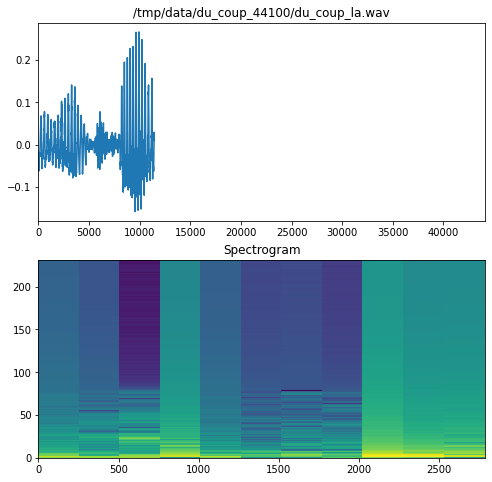

In [11]:
du_coup_files = os.listdir(os.path.join(data_dir, 'du_coup_44100'))
f = os.path.join(data_dir, 'du_coup_44100', du_coup_files[0])
wav, l = get_waveform_and_label(f)
s = get_spectrogram(wav)
show_wav_and_spectrogram(wav, s, f)

In [12]:
wav.shape

TensorShape([11452])

In [13]:
s.shape

TensorShape([12, 232, 1])

In [14]:
def perform_augmentation(waveform):
  waveforms = []
  spectrograms = []
  waveform_left = get_left_sample(waveform)
  waveform_center = get_center_sample(waveform)
  waveform_right = get_right_sample(waveform)
  waveform_noisy = get_noisy_sample(waveform)
  waveform_pitch = get_pitch_sample(waveform_center)
  waveform_stretched = get_stretched_sample(waveform)
  waveforms.append(waveform_left)
  waveforms.append(waveform_center)
  waveforms.append(waveform_right)
  waveforms.append(waveform_noisy)
  waveforms.append(waveform_pitch)
  waveforms.append(waveform_stretched)
  spectrograms.append(get_spectrogram(waveform_left))
  spectrograms.append(get_spectrogram(waveform_center))
  spectrograms.append(get_spectrogram(waveform_right))
  spectrograms.append(get_spectrogram(waveform_noisy))
  spectrograms.append(get_spectrogram(waveform_pitch))
  spectrograms.append(get_spectrogram(waveform_stretched))
  return waveforms, spectrograms

In [15]:
waveforms, spectrograms = perform_augmentation(wav)

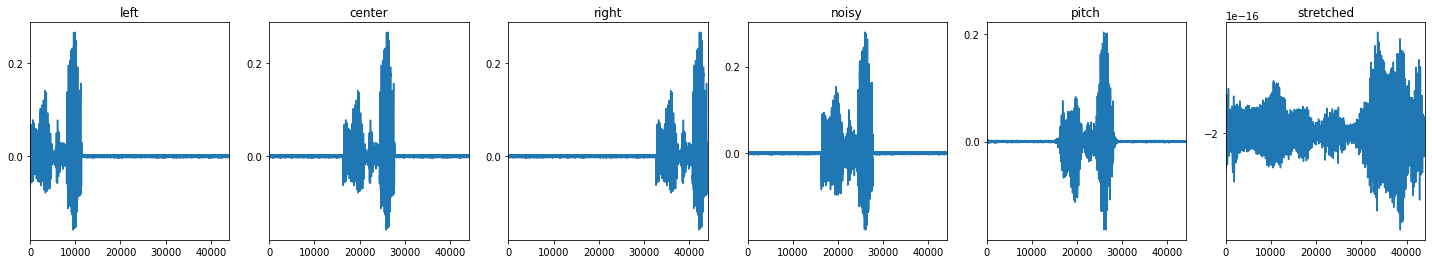

In [16]:
AUGMENTED_LABELS = ['left', 'center', 'right', 'noisy', 'pitch', 'stretched']
i = 0
fig = plt.figure(figsize=(25, 4))
for waveform in waveforms:
  ax = fig.add_subplot(1, len(waveforms), i + 1)
  ax.set_xlim([0, SAMPLING_RATE])
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.plot(waveform.numpy())
  ax.set_title(AUGMENTED_LABELS[i])
  i += 1

In [17]:
for waveform in waveforms:
  display.display(display.Audio(waveform, rate=SAMPLING_RATE))

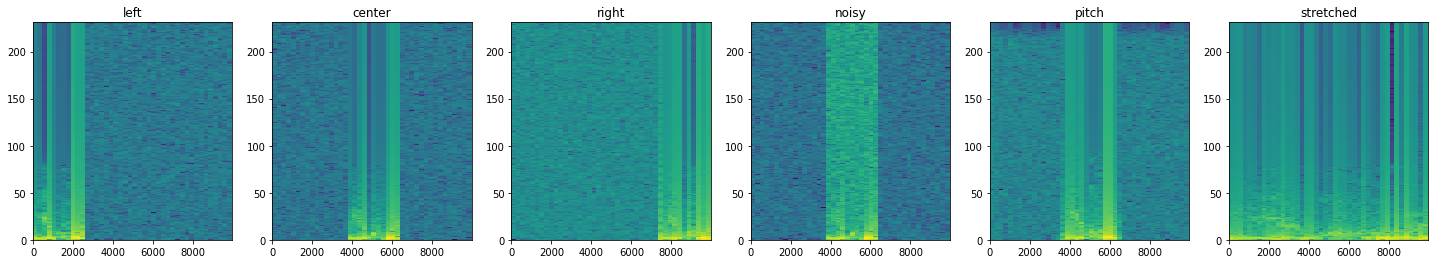

In [18]:
i = 0
fig = plt.figure(figsize=(25, 4))
for spectrogram in spectrograms:
  ax = fig.add_subplot(1, len(spectrograms), i + 1)
  show_spectrogram(spectrogram, AUGMENTED_LABELS[i], ax)
  i += 1

In [19]:
input_spectrograms_and_labels = []

i = 0
for word in ['unknown', 'background noise']:
  wav_paths = glob.glob(os.path.join(data_dir, word, "*.wav"))
  spectrograms = []
  for f in wav_paths:
    audio_binary = tf.io.read_file(f)
    waveform = decode_audio(audio_binary)
    spectrograms.append(get_spectrogram(waveform))
  print(word, ":", len(spectrograms), "spectrograms")
  labels = [i] * len(spectrograms)
  input_spectrograms_and_labels.extend(zip(spectrograms, labels))
  i += 1

du_coup_paths = glob.glob(os.path.join(data_dir, 'du_coup_44100', '*.wav'))
spectrograms = []
for f in du_coup_paths:
  audio_binary = tf.io.read_file(f)
  waveform = decode_audio(audio_binary)
  waveform_center = get_center_sample(waveform)
  spectrograms.append(get_spectrogram(get_left_sample(waveform)))
  spectrograms.append(get_spectrogram(waveform_center))
  spectrograms.append(get_spectrogram(get_right_sample(waveform)))
  spectrograms.append(get_spectrogram(get_noisy_sample(waveform)))
  spectrograms.append(get_spectrogram(get_pitch_sample(waveform_center)))
  spectrograms.append(get_spectrogram(get_stretched_sample(waveform)))
print("du coup : %d spectrograms" % (len(spectrograms)))
labels = [2] * len(spectrograms)
input_spectrograms_and_labels.extend(zip(spectrograms, labels))

random.shuffle(input_spectrograms_and_labels)

input_spectrograms, labels = ([t[0] for t in input_spectrograms_and_labels],
                              [t[1] for t in input_spectrograms_and_labels])

unknown : 697 spectrograms
background noise : 396 spectrograms
du coup : 1116 spectrograms


In [20]:
# Download the TensorFlow.js Speech Commands model and the associated
# preprocesssing model.
!mkdir -p /tmp/tfjs-sc-model
!curl -o /tmp/tfjs-sc-model/metadata.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/metadata.json
!curl -o /tmp/tfjs-sc-model/model.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/model.json
!curl -o /tmp/tfjs-sc-model/group1-shard1of2 -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard1of2
!curl -o /tmp/tfjs-sc-model/group1-shard2of2 -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard2of2
!curl -o /tmp/tfjs-sc-model/sc_preproc_model.tar.gz -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/conversion/sc_preproc_model.tar.gz
!cd /tmp/tfjs-sc-model/ && tar xzvf sc_preproc_model.tar.gz

sc_preproc_model/
sc_preproc_model/assets/
sc_preproc_model/variables/
sc_preproc_model/variables/variables.data-00000-of-00001
sc_preproc_model/variables/variables.index
sc_preproc_model/saved_model.pb


In [21]:
tfjs_model_json_path = '/tmp/tfjs-sc-model/model.json'

# Load the Speech Commands model. Weights are loaded along with the topology,
# since we train the model from scratch. Instead, we will perform transfer
# learning based on the model.
orig_model = tfjs.converters.load_keras_model(tfjs_model_json_path, load_weights=True)

# Remove the top Dense layer and add a new Dense layer of which the output
# size fits the number of sound classes we care about.
model = tf.keras.Sequential(name="TransferLearnedModel")
for layer in orig_model.layers[:-1]:
  model.add(layer)
model.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
for layer in model.layers[:-1]:
  layer.trainable = False

model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "TransferLearnedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32

In [22]:
ds = tf.data.Dataset.zip((
      tf.data.Dataset.from_tensor_slices(input_spectrograms),
      tf.data.Dataset.from_tensor_slices(labels)))

In [23]:
# The amount of data we have is relatively small. It fits into typical host RAM
# or GPU memory. For better training performance, we preload the data and
# put it into numpy arrays:
# - xs: The audio features (normalized spectrograms).
# - ys: The labels (class indices).
print(
    "Loading dataset and converting data to numpy arrays. "
    "This may take a few minutes...")
xs_and_ys = list(ds)
xs = np.stack([item[0] for item in xs_and_ys])
ys = np.stack([item[1] for item in xs_and_ys])
print("Done.")

Loading dataset and converting data to numpy arrays. This may take a few minutes...
Done.


In [24]:
# Train the model.
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

model.fit(xs, ys,
          batch_size=256,
          validation_split=0.3,
          shuffle=True,
          epochs=50,
          callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

Epoch 1/50
7/7 [==============================] - 4s 488ms/step - loss: 3.8697 - acc: 0.4832 - val_loss: 3.5197 - val_acc: 0.6048
Epoch 2/50
7/7 [==============================] - 3s 415ms/step - loss: 2.4586 - acc: 0.6003 - val_loss: 1.0030 - val_acc: 0.6998
Epoch 3/50
7/7 [==============================] - 3s 411ms/step - loss: 3.4957 - acc: 0.6119 - val_loss: 5.4441 - val_acc: 0.3906
Epoch 4/50
7/7 [==============================] - 3s 411ms/step - loss: 3.3481 - acc: 0.5783 - val_loss: 1.8299 - val_acc: 0.6787
Epoch 5/50
7/7 [==============================] - 3s 414ms/step - loss: 2.2838 - acc: 0.6210 - val_loss: 1.4773 - val_acc: 0.5747
Epoch 6/50
7/7 [==============================] - 3s 421ms/step - loss: 3.0464 - acc: 0.6481 - val_loss: 0.7770 - val_acc: 0.8009
Epoch 7/50
7/7 [==============================] - 3s 417ms/step - loss: 1.4713 - acc: 0.6999 - val_loss: 1.5370 - val_acc: 0.6199
Epoch 8/50
7/7 [==============================] - 3s 414ms/step - loss: 2.2710 - acc: 0.66

In [27]:
# Convert the model to TensorFlow.js Layers model format.
tfjs_model_dir = "/tmp/tfjs-model"
tfjs.converters.save_keras_model(model, tfjs_model_dir)

# Create the metadata.json file.
metadata = {"words": ['unknown', 'background noise', 'du_coup'], "frameSize": model.input_shape[-2]}
with open(os.path.join(tfjs_model_dir, "metadata.json"), "w") as f:
  json.dump(metadata, f)

In [30]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(tfjs_model_dir + '/group1-shard1of2.bin')
  files.download(tfjs_model_dir + '/group1-shard2of2.bin')
  files.download(tfjs_model_dir + '/metadata.json')
  files.download(tfjs_model_dir + '/model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>